# Composing Models

This is an example of adding a code example compiled with Literate.jl in the docs.

First we want to load our package with `using`

In [1]:
using SyntacticModels

using SyntacticModels.AMR
using SyntacticModels.ASKEMDecapodes
using SyntacticModels.ASKEMUWDs
using SyntacticModels.Composites

using MLStyle
import SyntacticModels.ASKEMDecapodes.Decapodes as Decapodes
using Catlab
using Catlab.RelationalPrograms
using Catlab.WiringDiagrams
using Test
using JSON3



x = Typed(:X, :Form0)
v = Typed(:V, :Form0)
Q = Typed(:Q, :Form0)

c = [x, Q]
s = [Statement(:oscillator, [x,v]),
  Statement(:heating, [v,Q])]
u = ASKEMUWDs.UWDExpr(c, s)



h = AMR.Header("harmonic_oscillator",
  "modelreps.io/DecaExpr",
  "A Simple Harmonic Oscillator as a Diagrammatic Equation",
  "DecaExpr",
  "v1.0")

SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "DecaExpr", "v1.0")

The easiest way to write down a DecaExpr is in our DSL and calling the parser.

In [2]:
dexpr = Decapodes.parse_decapode(quote
  X::Form0{Point}
  V::Form0{Point}

  k::Constant{Point}

  ∂ₜ(X) == V
  ∂ₜ(V) == -1*k*(X)
end
)

Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:k), :Constant, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:X)), Decapodes.Var(:V)), Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:V)), Decapodes.Mult(Decapodes.Term[Decapodes.Lit(Symbol("-1")), Decapodes.Var(:k), Decapodes.Var(:X)]))])

That gave us the first model

In [3]:
d1 = ASKEMDecaExpr(h, dexpr)

SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "DecaExpr", "v1.0"), Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:k), :Constant, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:X)), Decapodes.Var(:V)), Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:V)), Decapodes.Mult(Decapodes.Term[Decapodes.Lit(Symbol("-1")), Decapodes.Var(:k), Decapodes.Var(:X)]))]))

The second model is:

In [4]:
d2 = ASKEMDecaExpr(
  AMR.Header("fricative_heating",
   "modelreps.io/SummationDecapode",
   "Velocity makes it get hot, but you dissipate heat away from Q₀",
   "SummationDecapode", "v1.0"),
    Decapodes.parse_decapode(quote
      V::Form0{Point}
      Q::Form0{Point}
      κ::Constant{Point}
      λ::Constant{Point}
      Q₀::Parameter{Point}

      ∂ₜ(Q) == κ*V + λ(Q - Q₀)
    end)
)

SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("fricative_heating", "modelreps.io/SummationDecapode", "Velocity makes it get hot, but you dissipate heat away from Q₀", "SummationDecapode", "v1.0"), Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:Q), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:κ), :Constant, :Point), Decapodes.Judgement(Decapodes.Var(:λ), :Constant, :Point), Decapodes.Judgement(Decapodes.Var(:Q₀), :Parameter, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:Q)), Decapodes.Plus(Decapodes.Term[Decapodes.App2(:*, Decapodes.Var(:κ), Decapodes.Var(:V)), Decapodes.App1(:λ, Decapodes.App2(:-, Decapodes.Var(:Q), Decapodes.Var(:Q₀)))]))]))

Now we can assemble this bad boi:

In [5]:
h = AMR.Header("composite_physics", "modelreps.io/Composite", "A composite model", "CompositeModelExpr", "v0.0")
m = CompositeModelExpr(h, u, [OpenModel(d1, [:X, :V]), OpenModel(d2, [:V, :Q])])
interface(m) == [:X, :Q]
JSON3.write(m) # you can see from this little model (two coupled odes even) that the jsons will not be human editable.

"{\"components\":[{\"interface\":[\"X\",\"V\"],\"_type\":\"OpenModel\",\"model\":{\"header\":{\"description\":\"A Simple Harmonic Oscillator as a Diagrammatic Equation\",\"name\":\"harmonic_oscillator\",\"_type\":\"Header\",\"model_version\":\"v1.0\",\"schema\":\"modelreps.io/DecaExpr\",\"schema_name\":\"Deca" ⋯ 2150 bytes ⋯ "ar\":\"Q\",\"type\":\"Form0\",\"_type\":\"Typed\"}],\"_type\":\"UWDExpr\"},\"header\":{\"description\":\"A composite model\",\"name\":\"composite_physics\",\"_type\":\"Header\",\"model_version\":\"v0.0\",\"schema\":\"modelreps.io/Composite\",\"schema_name\":\"CompositeModelExpr\"},\"_type\":\"CompositeModelExpr\"}"

now we can interpret this big data structure to execute a composition!

Var,type,name
1,Form0,X
2,Form0,V
3,Constant,oscillator_k
4,infer,oscillator_mult_1
5,infer,oscillator_V̇
6,Literal,-1
7,Form0,Q
8,Constant,heating_κ
9,Constant,heating_λ
10,Parameter,heating_Q₀


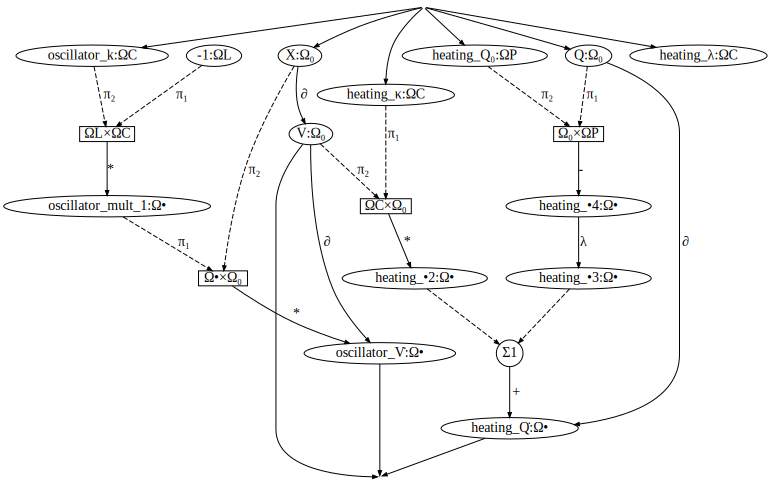

In [6]:
composite = oapply(m)
display(apex(composite))
to_graphviz(apex(composite))

TESTING NESTED COMPOSITION

In [7]:
Q₊ = Untyped(:Q₊)
Q₋ = Untyped(:Q₋)
Q̇ = Untyped(:Q̇)

uwdʰ = UWDExpr([v, Q], [Statement(:drag, [v, Q₊]), Statement(:cooling, [Q₋, Q]), Statement(:superposition, [Q₊, Q₋, Q̇])])

drag = ASKEMDecaExpr(
  AMR.Header("DragHeat", "modelreps.io/SummationDecapode", "velocity makes it get hot", "SummationDecapode", "v1.0"),
  Decapodes.parse_decapode(quote
    V::Form0{Point}
    Q₊::Form0{Point}
    κ::Constant{Point}

    Q₊ == κ*V
  end)
)

cooling = ASKEMDecaExpr(
  AMR.Header("NetwonCooling", "modelreps.io/SummationDecapode", "heat dissipates to the enviornment", "SummationDecapode", "v1.0"),
  Decapodes.parse_decapode(quote
    Q₋::Form0{Point}
    Q₀::Parameter{Point}
    Q::Form0{Point}
    λ::Constant{Point}

    Q₋ == λ(Q-Q₀)
  end)
)

superposition = ASKEMDecaExpr(
  AMR.Header("LinearSuperpositon", "modelreps.io/SummationDecapode", "variables be addin", "SummationDecapode", "v1.0"),
  Decapodes.parse_decapode(quote
    X::Form0{Point}
    Y::Form0{Point}
    T::Form0{Point}

    T == X + Y
  end)
)

h = AMR.Header("hierarchical_composite", "modelreps.io/Composite", "A hierarchical composite model of frictional heating", "CompositeModelExpr", "v0.1")
m = CompositeModelExpr(h,u, [OpenModel(d1, [:X, :V]),
      CompositeModelExpr(AMR.Header("heating_dynamics", "modelreps.io/Composite", "A formula for heating - cooling", "CompositeModelExpr", "v0.1"),
        uwdʰ, [OpenModel(drag, [:V, :Q₊]), OpenModel(cooling, [:Q₋, :Q]), OpenModel(superposition, [:X, :Y, :T])])
])

dh = apex(oapply(m))

composite = OpenDecapode(m)
hf = composite.model.header
ASKEMDecapode(Header("flattened_composite", hf.schema, "A flattened version of the composite_physics model.", hf.schema_name, hf.model_version), composite.model.model)

SyntacticModels.ASKEMDecapodes.ASKEMDecapode(SyntacticModels.AMR.Header("flattened_composite", "modelreps.io/Composite", "A flattened version of the composite_physics model.", "CompositeModelExpr", "v0.1"), Decapodes.SummationDecapode{Any, Any, Symbol}:
  Var = 1:14
  TVar = 1:2
  Op1 = 1:3
  Op2 = 1:4
  Σ = 1:1
  Summand = 1:2
  Type = 1:0
  Operator = 1:0
  Name = 1:0
  src : Op1 → Var = [1, 2, 13]
  tgt : Op1 → Var = [2, 5, 9]
  proj1 : Op2 → Var = [6, 4, 8, 11]
  proj2 : Op2 → Var = [3, 1, 2, 10]
  res : Op2 → Var = [4, 5, 7, 13]
  incl : TVar → Var = [2, 5]
  summand : Summand → Var = [7, 9]
  summation : Summand → Σ = [1, 1]
  sum : Σ → Var = [14]
  op1 : Op1 → Operator = [:∂ₜ, :∂ₜ, :λ]
  op2 : Op2 → Operator = [:*, :*, :*, :-]
  type : Var → Type = [:Form0, :Form0, :Constant, :infer, :infer, :Literal, :Form0, :Constant, :Form0, :Parameter, :Form0, :Constant, :infer, :Form0]
  name : Var → Name = [:X, :V, :oscillator_k, :oscillator_mult_1, :oscillator_V̇, Symbol("-1"), :heating_Q